# EE 508 HW 7: Transformer

Your task in this Colab notebook is to fill out the sections that are specified by **TODO** (please search the keyword `TODO` to make sure you do not miss any).

Prerequisites: set the runtime type to GPU. (Runtime -> Change Runtime Type)

## Initial Setup

This section imports all required packages from PyTorch and parameter initializations.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import math

# Define the source vocabulary size
src_vocab_size = 500

# Define the target vocabulary size
tgt_vocab_size = 500

# Define the model's dimensionality (size of embeddings and hidden layers)
d_model = 512

# Define the number of attention heads in multi-head attention layers
num_heads = 8

# Define the number of encoder and decoder layers in the transformer
num_layers = 4

# Define the dimension of the feed-forward network in each layer
d_ff = 2048

# Define the maximum sequence length for input and output sequences
max_seq_length = 50

# Define the dropout rate (0 for no dropout, otherwise specify a value)
dropout = 0.1

## Multi-Head Attention Block

In the Transformer architecture, multi-head attention operates as follows:

1. Linear Projection: Input is linearly projected into queries (Q), keys (K), and values (V) for each attention head, diversifying the data representation.

2. Calculate Attention: Each head computes attention scores using the equation:
    $$\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{SoftMax}\left(\frac{\mathbf{Q} \mathbf{K}^T}{\sqrt{d_k}}\right) \mathbf{V}$$
    It scales the dot-product of Q and K, normalizes scores with softmax to obtain probabilities, and calculates a weighted sum of V, allowing each head to focus on different parts of the input.

3. Combine Outputs: Outputs from all heads are concatenated and passed through a linear transformation to produce the final output, integrating the insights from each head into a unified representation.


Note that the input and output linear layers in steps 1 and 3 are not depicted in the picture below.

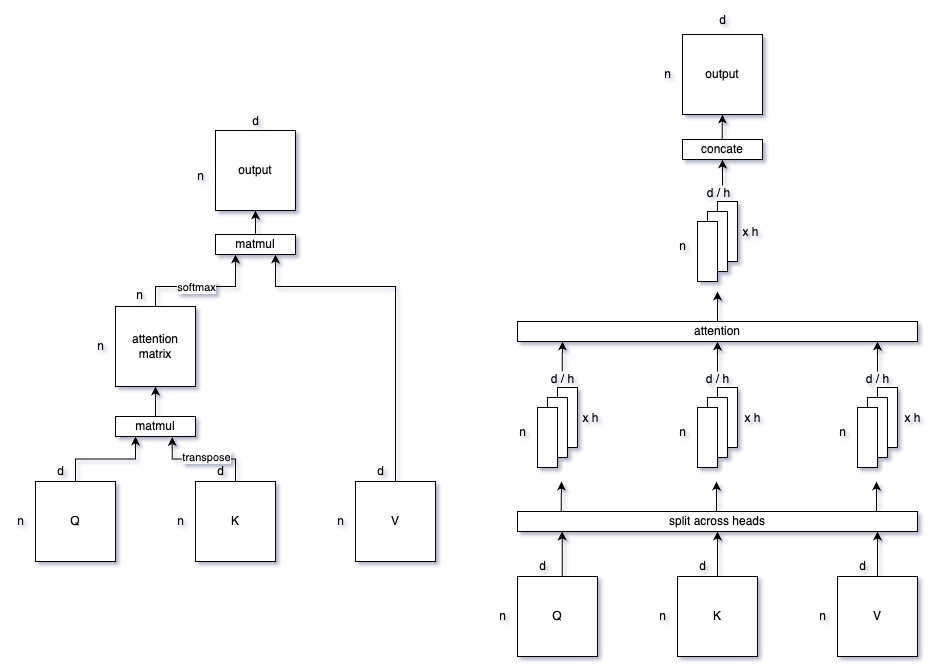

### **TODO 1:**
Finish functions `scaled_dot_product_attention` and `forward`.

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()

        # Check if d_model is divisible by num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Store d_model and num_heads
        self.d_model = d_model
        self.num_heads = num_heads

        # Calculate dimension of each head
        self.d_k = d_model // num_heads

        # Linear transformations for queries, keys, values, and output
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # TODO: Implement the scaled dot product attention.
        # Your task is to calculate attention scores using the dot product
        # between Q and K, scale these scores and apply a mask if provided.
        # Finally, calculate the output as a weighted sum of V.

        # Calculate attention scores using dot product and scale by sqrt(d_k)
        # (assuming a shape like [batch_size, sequence_length, embedding_dimension]) for K.

        scores = torch.matmul(Q, K.transpose(-2, -1))
        scores = scores / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention_weights = torch.functional.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)

        return output, attention_weights

    def split_heads(self, x):
        # TODO: Implement the split_heads function.
        # Your task is to reshape the input tensor x so that it is split
        # into multiple heads for multi-head attention.
        # Reshape input into multiple heads
        # The final shape should be
        # (batch_size, num_heads, seq_length, d_k)

        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # TODO: Combine multiple heads into original shape
        # Finale shape is (batch_size, seq_length, d_model)
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # TODO: Implement the forward pass for the MultiHeadAttention.
        # Your task is to transform Q, K, V linearly, split them into multiple heads,
        # apply scaled dot product attention, combine the heads back and apply
        # the final linear transformation.

        # Linearly transform queries, keys, and values for each head

        Q = self.W_q(Q)  # shape: [batch_size, seq_length, d_model]
        K = self.W_k(K)  # shape: [batch_size, seq_length, d_model]
        V = self.W_v(V)  # shape: [batch_size, seq_length, d_model]

        Q = self.split_heads(Q)  # shape: [batch_size, num_heads, seq_length, d_k]
        K = self.split_heads(K)  # shape: [batch_size, num_heads, seq_length, d_k]
        V = self.split_heads(V)  # shape: [batch_size, num_heads, seq_length, d_k]

        attention_output, _ = self.scaled_dot_product_attention(Q, K, V, mask)

        combined_output = self.combine_heads(attention_output)

        output = self.W_o(combined_output)

        return output

## Positional Encoding

The `PositionalEncoding` class adds positional information to input sequences using a sinusoidal function, enabling the Transformer model to consider the order of tokens. The encoding for a position `pos` and dimension `i` in the input is defined as follows:

$$
\text{PE(pos, i)} =
\begin{cases}
\sin\left(\frac{\text{pos}}{10000^{\frac{2i}{d_{\text{model}}}}}\right), & \text{if i is even} \\
\cos\left(\frac{\text{pos}}{10000^{\frac{2i}{d_{\text{model}}}}}\right), & \text{if i is odd}
\end{cases}
$$

where
* `pos` represents the position of the token in the sequence.
* `i` refers to the dimension within the embedding space.
* `d_model` is the total size of the embeddings.

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        # Initialize a matrix 'pe' to store positional encodings.
        pe = torch.zeros(max_seq_length, d_model)

        # Create a 'position' tensor to represent positions from 0 to 'max_seq_length - 1'.
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)

        # Calculate the 'div_term' tensor to scale the sine and cosine functions.
        # Note that a^b = exp(b * log(a))
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        # Calculate sine and cosine positional encodings for each position and dimension.
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register 'pe' as a buffer so it's not considered a model parameter.
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # Add the positional encodings to the input tensor 'x'.
        return x + self.pe[:, :x.size(1)]

## Position-wise Feed Forward Block

The Position-Wise Feed-Forward Network (FFN) consists of two fully connected dense layers, or a multi-layer perceptron (MLP). The hidden layer, which is known as `d_ffn`, is generally set to a value about four times that of `d_model`. This is why it is sometimes known as an expand-and-contract network.

It is known as a “position-wise” network because it “transforms the representation at all the sequence positions using the same MLP.” In other words, the FNN has a size of (`d_model`, `d_ffn`) in its first layer, which means it has to be broadcast across each sequence during tensor multiplication. This means each sequence is multiplied by the same weights. If identical sequences are input, the outputs will also be identical. This same logic applies to the second dense layer of size (`d_ffn`, `d_model`), which returns the tensor to its original size.

The ReLU activiation function is used between the layers. Any values greater than 0 remain the same, and any values less than or equal to 0 become 0. It introduces non-linearity and helps prevent vanishing gradients.

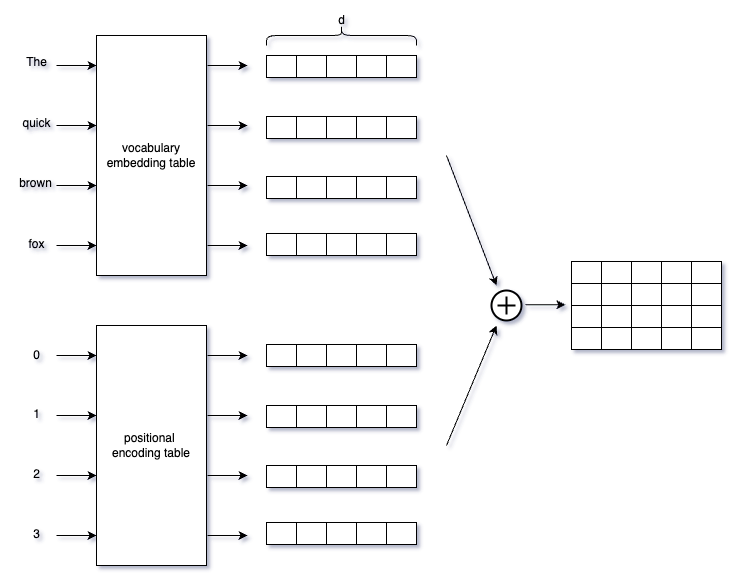

### **TODO 2:**
Finish the function `forward`.

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()

        # First linear layer (input dimension to intermediate dimension)
        self.fc1 = nn.Linear(d_model, d_ff)

        # Second linear layer (intermediate dimension to output dimension)
        self.fc2 = nn.Linear(d_ff, d_model)

        # ReLU activation function to introduce non-linearity
        self.relu = nn.ReLU()

    def forward(self, x):
        # TODO: Implement the forward pass for the PositionWiseFeedForward.
        # Your task is to apply the first linear layer (self.fc1) to the input x,
        # then apply a ReLU activation function, followed by applying the second
        # linear layer (self.fc2). The goal is to transform the input and then
        # map it back to the original dimension.

        # Apply first linear layer
        x = self.fc1(x)

        # Apply ReLU activation function
        x = self.relu(x)

        # Apply second linear layer to map back to original dimension
        x = self.fc2(x)

        pass

## Encoder Layer

The `EncoderLayer` represents one layer of the encoder stack in the Transformer model. It takes an input tensor `x` and a `mask` (used in the self-attention mechanism), applies multi-head self-attention, position-wise feedforward operations, layer normalization, and dropout.

The layer normalization and dropout are used to enhance the model's stability and prevent overfitting.

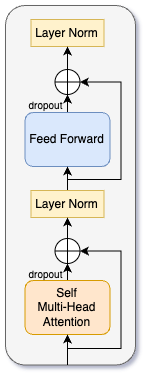

### **TODO 3:**
Finish the function `forward`.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        # Multi-head self-attention layer
        self.self_attn = MultiHeadAttention(d_model, num_heads)

        # Position-wise feedforward network
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)

        # Layer normalization after self-attention and feedforward
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # TODO: Implement the forward pass for the EncoderLayer.
        # Your task is to apply multi-head self-attention on the input x using
        # the self.self_attn layer with a residual connection and layer normalization.
        # Next, apply the position-wise feedforward network using self.feed_forward
        # with another residual connection and layer normalization.
        # Remember to include dropout for regularization.

        pass

## Decoder Layer

The `DecoderLayer` represents one layer of the decoder stack in the Transformer model. It takes an input tensor `x`, the encoder's output `enc_output`, and masks for both the source (`src_mask`) and target (`tgt_mask`) sequences.

The layer performs self-attention, cross-attention, and feedforward operations, followed by layer normalization and dropout for regularization.

The residual connections ensure that information from previous layers is preserved, and layer normalization stabilizes the activations.

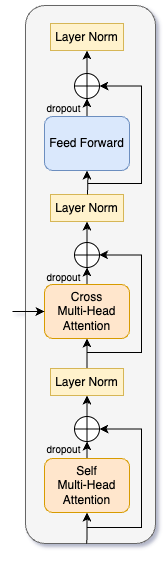

### **TODO 4:**
Finish the function `forward`.

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        # Self-attention layer within the decoder
        self.self_attn = MultiHeadAttention(d_model, num_heads)

        # Cross-attention layer between decoder and encoder
        self.cross_attn = MultiHeadAttention(d_model, num_heads)

        # Position-wise feedforward network
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)

        # Layer normalization after each sub-layer
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        # TODO: Implement the forward pass for the DecoderLayer.
        # Your task is to apply self-attention on the input x using self.self_attn
        # with a residual connection and layer normalization. Next, apply cross-attention
        # using self.cross_attn, with the encoder output as key and value, and a residual
        # connection and layer normalization. Finally, apply the position-wise feedforward
        # network using self.feed_forward with another residual connection and layer normalization.
        # Remember to use dropout for regularization where appropriate.

        pass

## The Transformer Class

In this class we put together the encoder and decoder layers.

Note that we define two types of masks, one for encoder and one for decoder:

1. Source Mask (`src_mask`): The source mask is applied to the source sequence (usually the input sequence). It is used to mask positions in the source sequence where padding tokens are present. Padding tokens are often used in sequences with varying lengths, and the mask ensures that the model does not attend to or consider the padding positions during processing.

2. Target Mask (`tgt_mask`): The target mask is applied to the target sequence (usually the output or target sequence). It serves two purposes:
    * First, it masks positions in the target sequence where padding tokens are present, similar to the source mask.
    * Second, it includes a "no-peek" mask, which is used to prevent the decoder from looking ahead during sequence generation. This is achieved by creating a triangular mask with ones below the main diagonal and zeros above the diagonal using torch.triu. This mask ensures that each position in the target sequence can only attend to or consider positions that precede it, maintaining the causal nature of sequence generation. The no-peek mask is applied after the padding mask.

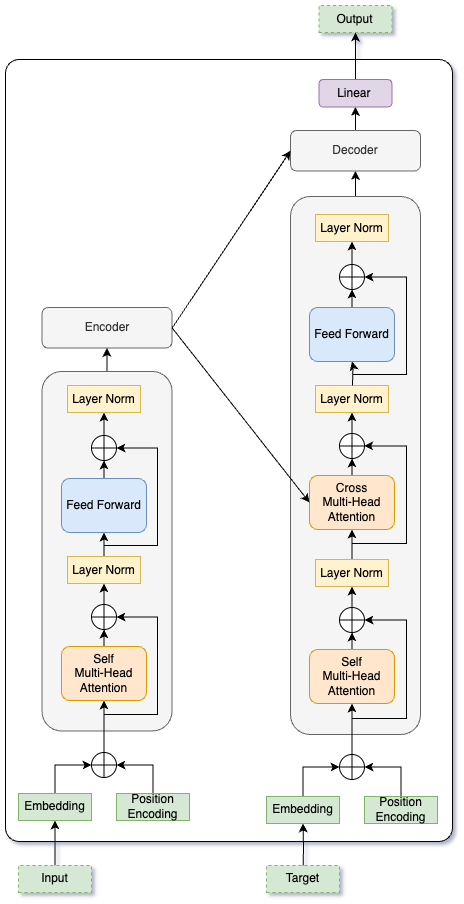

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()

        # Embedding layers for the source and target sequences
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)

        # Positional encoding for both source and target sequences
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        # Stacks of encoder and decoder layers
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        # Fully connected layer for output prediction
        self.fc = nn.Linear(d_model, tgt_vocab_size)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        # Generate masks for the source and target sequences
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)

        # Create a no-peek mask to prevent the decoder from looking ahead
        nopeek_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeek_mask.to(tgt_mask.device)

        return src_mask, tgt_mask

    def forward(self, src, tgt):
        # TODO: Implement the forward pass for the Transformer.
        # Your task is to generate masks for the source and target sequences.
        # Then embed the source and target sequences, apply positional encoding,
        # and pass them through the stacks of encoder and decoder layers.
        # Finally, apply the fully connected layer to get the output prediction.
        # Remember to use dropout where appropriate.

        # Generate masks for source and target sequences
        src_mask, tgt_mask = self.generate_mask(src, tgt)

        # Embed source and target sequences and apply positional encoding
        # Apply dropout to the embeddings
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        # Encoder: Apply multiple encoder layers to the source sequence
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        # Decoder: Apply multiple decoder layers to the target sequence
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        # Fully connected layer for output prediction
        output = self.fc(dec_output)

        return output

## Create A Simple Word Tokenizer

The SimpleWordTokenizer class is responsible for tokenizing and encoding sentences into sequences of token IDs and decoding sequences of token IDs back into human-readable sentences.

The tokenization process in the SimpleWordTokenizer class involves several steps.

-  First, it converts the input sentence to lowercase to ensure uniformity.
-  Then, it employs regular expressions to tokenize the sentence, distinguishing between words and punctuation. It uses a regular expression pattern to capture words, including accented characters in languages like Spanish and English, and also captures punctuation marks.
- The tokenizer adds special start-of-sequence (\<sos\>) and end-of-sequence (\<eos\>) tokens to mark the beginning and end of the sequence. These tokens, along with the tokens obtained from the regular expression, are organized into a list.
- Each token is then mapped to its corresponding index in the vocabulary, with unknown words assigned index 0. This resulting list of token IDs represents the tokenized and encoded form of the input sentence.


Example:

```python
# Example usage
vocabulary = ["hello", "hola", ",", "how", "cómo", "are", "estás", "you", "tú", "?", "¡", "¿"]
tokenizer = SimpleWordTokenizer(vocabulary)

encoded_sentence = tokenizer.encode("¿Hola, cómo estás tú?")
decoded_sentence = tokenizer.decode(encoded_sentence)
print("Encoded:", encoded_sentence)
print("Decoded:", decoded_sentence)

```

Output:

```
Encoded: [1, 3, 4, 5, 6, 7, 8, 2]
Decoded: <sos> hello , how are you ? <eos>
```

Another example:

```python
# Example usage
vocabulary = ["hello", ",", "how", "are", "you", "?"]
tokenizer = SimpleWordTokenizer(vocabulary)

encoded_sentence = tokenizer.encode("hello, how are you?")
decoded_sentence = tokenizer.decode(encoded_sentence)
print("Encoded:", encoded_sentence)
print("Decoded:", decoded_sentence)
```


Output:

```
Encoded: [1, 14, 4, 5, 7, 9, 11, 12, 2]
Decoded: <sos> ¿ hola , cómo estás tú ? <eos>
```


In [ ]:
import re

class SimpleWordTokenizer:
    def __init__(self, vocabulary):
        # Add SOS and EOS tokens to the vocabulary
        self.SOS_TOKEN = "<sos>"  # Start-of-sequence token
        self.EOS_TOKEN = "<eos>"  # End-of-sequence token

        # Extend the vocabulary with SOS and EOS tokens
        extended_vocab = [self.SOS_TOKEN, self.EOS_TOKEN] + vocabulary

        # Check if the provided vocabulary is valid
        if not extended_vocab or not isinstance(extended_vocab, list):
            raise ValueError("Vocabulary must be a non-empty list of words.")

        # Create word-to-index and index-to-word dictionaries
        self.word2idx = {word: idx for idx, word in enumerate(extended_vocab, start=1)}  # Start at 1 to reserve 0 for padding
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        # TODO: Implement the encode method for the SimpleWordTokenizer.
        # Your task is to convert the input sentence to lowercase,
        # tokenize the sentence into words and punctuation using regular expressions,
        # and then convert each token to its corresponding index in the vocabulary.
        # If a token is not in the vocabulary, use 0 to represent it.

        # Convert the input sentence to lowercase
        sentence = sentence.lower()
        # Enhanced tokenization: split words and punctuation using regular expression
        # Regex pattern to capture words (including accented characters in Spanish and English) and punctuation
        tokens = [self.SOS_TOKEN] + re.findall(r"[\wáéíóúüñÁÉÍÓÚÜÑ]+|[^\w\s]", sentence, re.UNICODE) + [self.EOS_TOKEN]
        return [self.word2idx.get(token, 0) for token in tokens]  # 0 for unknown words

    def decode(self, token_ids):
        # TODO: Implement the decode method for the SimpleWordTokenizer.
        # Your task is to convert a list of token IDs back into a readable sentence.
        # You should convert each token ID to its corresponding word in the vocabulary.
        # If a token ID is not in the vocabulary, use "<unk>" to represent it.
        # Additionally, decide how to handle the special tokens like <sos> and <eos>.

        # Decode each token ID to a word
        decoded_tokens = []
        for token_id in token_ids:
            # if token_id == self.word2idx[self.SOS_TOKEN] or token_id == self.word2idx[self.EOS_TOKEN]:
            #     # Skip <sos> and <eos> tokens in the decoded output
            #     continue
            decoded_tokens.append(self.idx2word.get(token_id, "<unk>"))  # Use <unk> for unknown words
        return ' '.join(decoded_tokens)

# Example usage
vocabulary = ["hello", "hola", ",", "how", "cómo", "are", "estás", "you", "tú", "?", "¡", "¿"]
tokenizer = SimpleWordTokenizer(vocabulary)

encoded_sentence = tokenizer.encode("¿Hola, cómo estás tú?")
decoded_sentence = tokenizer.decode(encoded_sentence)
print("Encoded:", encoded_sentence)
print("Decoded:", decoded_sentence)


# Example usage
vocabulary = ["hello", ",", "how", "are", "you", "?"]
tokenizer = SimpleWordTokenizer(vocabulary)

encoded_sentence = tokenizer.encode("hello, how are you?")
decoded_sentence = tokenizer.decode(encoded_sentence)
print("Encoded:", encoded_sentence)
print("Decoded:", decoded_sentence)

## Padding Function

The `pad_sequences` function takes a list of variable-length sequences and pads them to a specified maximum length, resulting in a batch of sequences with consistent lengths.

Padding is achieved using zeros, and the function returns the padded sequences as PyTorch tensors.


In [ ]:
# Padding function
def pad_sequences(sequences, max_len):
    # TODO: Implement the pad_sequences function.
    # Your task is to convert each sequence in the list to a PyTorch tensor,
    # pad these sequences to have a consistent length using torch.nn.utils.rnn.pad_sequence,
    # ensure that the length of each sequence does not exceed 'max_len',
    # and optionally convert the result to int64 data type.
    # Remember to handle the padding value appropriately.

    # Convert each sequence in the list to a PyTorch tensor
    tensor_sequences = [torch.tensor(seq) for seq in sequences]

    # Pad the sequences to have a consistent length using torch.nn.utils.rnn.pad_sequence
    padded_sequences = torch.nn.utils.rnn.pad_sequence(tensor_sequences, batch_first=True, padding_value=0)

    # Ensure the padded sequences have a maximum length of 'max_len' by slicing
    padded_sequences = padded_sequences[:, :max_len]

    # Convert the result to int64 data type (optional, depending on your needs)
    padded_sequences = padded_sequences.to(torch.int64)

    return padded_sequences

## Data Collection

In this section, we should use a Bilingual dataset from a target language to a source language.

We prepare English and Spanish sentences for sequence-to-sequence tasks by creating vocabularies, tokenizing and encoding the sentences, and padding the sequences to ensure consistent sequence lengths for further processing.

Ideally we should use an open source dataset, but for simplicity, we just use a minimal dataset here.

In [ ]:
english_sentences=[
    "Hello, how are you?",  # English
    "What is your name?",
    "I am learning Spanish.",
    "This is a book.",
    "The weather is nice today.",
    "Where is the nearest restaurant?",
    "Can you help me?",
    "I love reading books.",
    "How much does this cost?",
    "I need to call a doctor.",
    "What time is it?",
    "Can I order this online?",
    "The weather is very nice today.",
    "I am going to the supermarket.",
    "Do you speak English?",
    # Add more sentences here...
]

spanish_sentences=[
    "Hola, ¿cómo estás?",  # Spanish
    "¿Cómo te llamas?",
    "Estoy aprendiendo español.",
    "Este es un libro.",
    "El clima está agradable hoy.",
    "¿Dónde está el restaurante más cercano?",
    "¿Puedes ayudarme?",
    "Me encanta leer libros.",
    "¿Cuánto cuesta esto?",
    "Necesito llamar a un médico.",
    "¿Qué hora es?",
    "¿Puedo pedir esto en línea?",
    "El clima está muy agradable hoy.",
    "Voy al supermercado.",
    "¿Hablas inglés?",
    # Add more sentences here...
]


english_sentences.extend([
    "I enjoy traveling.",
    "Where is the nearest airport?",
    "What's your favorite movie?",
    "Do you have any siblings?",
    "Can you recommend a good restaurant?",
    "I like to play soccer.",
    "How do I get to the museum?",
    "I'm feeling tired today.",
    "What's the weather like tomorrow?",
    "I have a meeting at 2 PM.",
    "How was your weekend?",
    "What's your favorite book?",
    "I need to buy some groceries.",
    "I'm going to the gym later.",
    "Do you have any pets?",
    # Add more sentences here...
])

spanish_sentences.extend([
    "Disfruto viajar.",
    "¿Dónde está el aeropuerto más cercano?",
    "¿Cuál es tu película favorita?",
    "¿Tienes hermanos?",
    "¿Puedes recomendar un buen restaurante?",
    "Me gusta jugar al fútbol.",
    "¿Cómo llego al museo?",
    "Hoy me siento cansado.",
    "¿Cómo estará el clima mañana?",
    "Tengo una reunión a las 2 PM.",
    "¿Cómo fue tu fin de semana?",
    "¿Cuál es tu libro favorito?",
    "Necesito comprar algunos víveres.",
    "Voy al gimnasio más tarde.",
    "¿Tienes mascotas?",
    # Add more sentences here...
])

english_sentences.extend([
    "What's your favorite color?",
    "I enjoy hiking in the mountains.",
    "Have you visited Paris before?",
    "Could you please pass the salt?",
    "I'm planning a trip to Italy.",
    "What's the capital of Spain?",
    "I love listening to music.",
    "Is there a pharmacy nearby?",
    "Do you like cooking?",
    "I'll be there in 10 minutes.",
    "What's your favorite type of cuisine?",
    "How do you say 'hello' in Spanish?",
    "I need to buy a birthday gift.",
    "I can speak three languages.",
    "Let's go for a walk in the park.",
    # Add more sentences here...
])

spanish_sentences.extend([
    "¿Cuál es tu color favorito?",
    "Disfruto de hacer senderismo en las montañas.",
    "¿Has visitado París antes?",
    "¿Podrías pasarme la sal, por favor?",
    "Estoy planeando un viaje a Italia.",
    "¿Cuál es la capital de España?",
    "Me encanta escuchar música.",
    "¿Hay una farmacia cerca?",
    "¿Te gusta cocinar?",
    "Estaré allí en 10 minutos.",
    "¿Cuál es tu tipo de cocina favorito?",
    "¿Cómo se dice 'hola' en español?",
    "Necesito comprar un regalo de cumpleaños.",
    "Puedo hablar tres idiomas.",
    "Vamos a dar un paseo en el parque.",
    # Add more sentences here...
])

english_sentences.extend([
    "I just finished reading a fascinating book.",
    "What's your all-time favorite book?",
    "I can't put this book down; it's so captivating.",
    "Do you prefer reading e-books or physical books?",
    "I'm looking for a good mystery book to read.",
    "Reading a book is a great way to relax.",
    "I've heard great reviews about that book.",
    "Can you recommend a book for my book club?",
    "This bookstore has a wide selection of books.",
    "I love the smell of old books in a library.",
    "I'm trying to find a rare and collectible book.",
    "The author of this book is a renowned writer.",
    "I often visit the local library to borrow books.",
    "I enjoy discussing books with fellow readers.",
    "There's nothing like getting lost in a good book.",
    # Add more sentences here...
])

spanish_sentences.extend([
    "Acabo de terminar de leer un libro fascinante.",
    "¿Cuál es tu libro favorito de todos los tiempos?",
    "No puedo dejar este libro; es tan cautivador.",
    "¿Prefieres leer libros electrónicos o libros físicos?",
    "Estoy buscando un buen libro de misterio para leer.",
    "Leer un libro es una excelente forma de relajarse.",
    "He escuchado excelentes críticas sobre ese libro.",
    "¿Puedes recomendarme un libro para mi club de lectura?",
    "Esta librería tiene una amplia selección de libros.",
    "Me encanta el olor de los libros antiguos en una biblioteca.",
    "Estoy tratando de encontrar un libro raro y coleccionable.",
    "El autor de este libro es un escritor de renombre.",
    "A menudo visito la biblioteca local para tomar libros prestados.",
    "Disfruto discutiendo libros con otros lectores.",
    "No hay nada como perderse en un buen libro.",
    # Add more sentences here...
])




# Function to create vocabularies from sentences
def create_vocabulary(sentences):
    vocabulary = set()
    for sentence in sentences:
        sentence = sentence.lower()
        words = re.findall(r"[\wáéíóúüñÁÉÍÓÚÜÑ]+|[^\w\s]", sentence, re.UNICODE)   # Simple split; consider better tokenization in real applications
        vocabulary.update(words)
    return list(vocabulary)

# Create vocabularies from the sentences
english_vocab = create_vocabulary(english_sentences)
spanish_vocab = create_vocabulary(spanish_sentences)

# Initialize tokenizers with created vocabularies
english_tokenizer = SimpleWordTokenizer(english_vocab)
spanish_tokenizer = SimpleWordTokenizer(spanish_vocab)

# Tokenize and encode the sentences using the tokenizers
src_data_encoded = [english_tokenizer.encode(sentence) for sentence in english_sentences]
tgt_data_encoded = [spanish_tokenizer.encode(sentence) for sentence in spanish_sentences]

# Pad the sequences to a maximum sequence length
src_data_padded = pad_sequences(src_data_encoded, max_seq_length)
tgt_data_padded = pad_sequences(tgt_data_encoded, max_seq_length)

## Training the Transformer

Train the Transformer model using the provided data (source and target sequences) with the specified hyperparameters and loss function.

The model's parameters are updated iteratively through backpropagation to minimize the loss, and training progress is monitored by printing the loss at each epoch.

Use `nn.CrossEntropyLoss` for the loss function and Adam optimizer.

In [ ]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the transformer model
transformer = Transformer(len(english_vocab)+3, len(spanish_vocab)+3, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Define the loss criterion (CrossEntropyLoss) with the 'ignore_index' option
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Initialize the optimizer (Adam) for training the transformer
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# Move the transformer model to GPU
transformer.to(device)

# Set the transformer model to training mode
transformer.train()



# TODO: Implement the training loop for the transformer model.
# Your task is to loop through epochs, perform a forward pass to compute the output of the transformer model,
# calculate the loss, and perform backpropagation to update the model parameters.
# You need to consider the shape of the output and the target data when calculating the loss.
# Additionally, implement appropriate print statements to monitor the training progress.
# Don't forget to zero out the gradients at the beginning of each epoch.
# This prevents the accumulation of gradients from multiple forward passes,
# which can lead to incorrect updates during training.

# Training loop
for epoch in range(50):

    optimizer.zero_grad()

    # Forward pass: Compute the output of the transformer model
    # [:, :-1] is used to exclude the last token from each sequence
    output = transformer(src_data_padded.to(device), tgt_data_padded[:, :-1].to(device))

    # Calculate the loss by comparing the predicted output with the target sequences
    # The '+3' accounts for special tokens: sos, eos, and padding (represented by index 0).

    # 'output' is the predicted output of the Transformer model, which is a tensor of shape [batch_size, seq_length, vocab_size],
    # where 'vocab_size' is the size of the target vocabulary, including the special tokens.

    # The '.contiguous()' method is used to ensure that the tensor is stored in a contiguous block of memory.
    # This is important for compatibility with certain operations like view() that require contiguous memory.

    # '.view(-1, len(spanish_vocab)+3)' reshapes the 'output' tensor into a 2D tensor where the first dimension
    # is automatically determined to match the size of the original tensor, and the second dimension is set to 'len(spanish_vocab)+3'.
    # This effectively flattens the predicted output for each sequence token in the batch.

    # 'tgt_data_padded[:, 1:].contiguous().view(-1)' does a similar reshaping and flattening for the target sequences.
    # 'tgt_data_padded[:, 1:]' removes the first token from each target sequence (usually the '<sos>' token)
    # as it's not used for loss calculation.

    # The CrossEntropyLoss criterion then computes the loss by comparing the flattened predicted output
    # with the flattened target sequences, taking into account the special tokens and padding.

    loss = criterion(output.contiguous().view(-1, len(spanish_vocab)+3), tgt_data_padded[:, 1:].contiguous().view(-1).to(device))

    # Backpropagation: Compute gradients and update model parameters
    loss.backward()
    optimizer.step()

    # Print the current epoch and loss for monitoring training progress
    print(f"Epoch: {epoch+1}, Loss: {loss.item():.5f}")

## Inference


In this coding Section, you will implement a [Beam Search algorithm](https://en.wikipedia.org/wiki/Beam_search) for sequence-to-sequence translation using a pre-trained Transformer model.

Beam Search is a widely used decoding technique in natural language processing to generate translations or sequences of text. The goal of your code is to take a source sentence in one language, tokenize and encode it, and then generate the best possible translation in another language.

You will utilize the Transformer model, which has been trained for this task, and use the beam search approach to explore multiple translation hypotheses efficiently.

The provided code initializes with an initial hypothesis containing only the start-of-sentence token.

You will extend this hypothesis by selecting the top-k most likely tokens at each step, where k is the beam width.

You'll sort and prune hypotheses based on their log probabilities and ultimately return the best translation.

Be sure to handle special tokens such as the start-of-sentence and end-of-sentence tokens appropriately.

Also, ensure that your code operates efficiently and adheres to best practices in PyTorch for inference with a pre-trained model.


In [ ]:
def beam_search(model, sentence, src_tokenizer, tgt_tokenizer, max_length=20, sos_token_id=1, eos_token_id=2, beam_width=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()  # Set the model to evaluation mode
    model.to(device)

    # Tokenize and encode the input sentence using src_tokenizer
    src_tokens = src_tokenizer.encode(sentence)
    src_tensor = torch.tensor([src_tokens]).to(torch.int64).to(device)  # Add batch dimension

    # Initialize the initial hypothesis with the start of sentence token
    initial_hypothesis = [(sos_token_id, [sos_token_id], 0)]  # (current_token, sequence, log_probability)

    # Initialize a list to store completed translations
    completed_translations = []

    for _ in range(max_length):
        new_hypotheses = []

        for token, sequence, log_prob in initial_hypothesis:
            if token == eos_token_id:
                # If the sequence ends with an EOS token, add it to completed translations
                completed_translations.append((sequence, log_prob))
                continue

            # Prepare input tensor for the current hypothesis
            tgt_tensor = torch.tensor([sequence]).to(torch.int64).to(device)  # Add batch dimension

            with torch.no_grad():
                output = model(src_tensor, tgt_tensor)

            # Get the top-k tokens and their log probabilities
            topk_tokens = output[0, -1, :].topk(beam_width)
            for next_token, next_log_prob in zip(topk_tokens.indices, topk_tokens.values):
                new_sequence = sequence + [next_token.item()]
                new_log_prob = log_prob + next_log_prob.item()

                new_hypotheses.append((next_token.item(), new_sequence, new_log_prob))

        # Sort hypotheses by log probability and keep the top-k
        new_hypotheses.sort(key=lambda x: x[2], reverse=True)
        initial_hypothesis = new_hypotheses[:beam_width]

    # Add any remaining completed translations
    completed_translations.extend([(sequence, log_prob) for _, sequence, log_prob in initial_hypothesis if sequence[-1] == eos_token_id])

    if not completed_translations:
        return "Translation not found"  # No translations found

    # Sort completed translations by log probability and return the best one
    completed_translations.sort(key=lambda x: x[1], reverse=True)
    best_translation = completed_translations[0][0]

    # Decode the best translation back to words
    translated_sentence = tgt_tokenizer.decode(best_translation)  # Skip start and end tokens

    return translated_sentence

# Now let's translate!
translated = beam_search(transformer, "What's your favorite color?", english_tokenizer, spanish_tokenizer)
print(translated)

translated = beam_search(transformer, "Reading a book is a great way to relax.", english_tokenizer, spanish_tokenizer)
print(translated)